In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from ipywidgets import interact, fixed, IntSlider, Checkbox
from pathlib import Path
# Instalamos el paquete de utilidades
%pip install -qq git+https://github.com/udesa-vision/i308-utils.git

from i308_utils import imshow, show_images
from utils import rectify_stereo_pair, draw_epipolar_lines, show_pair_any, compute_depth

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Cargamos los archivos y analizamos el contenido
with open('data/pkls/stereo_calibration.pkl', 'rb') as f:
    calib = pickle.load(f)

with open('data/pkls/stereo_maps.pkl', 'rb') as f:
    maps = pickle.load(f)

print('Calibration keys:', calib.keys())
print('Maps keys:', maps.keys())

Calibration keys: dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
Maps keys: dict_keys(['left_map_x', 'left_map_y', 'right_map_x', 'right_map_y', 'R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2'])


Pares rectificados: 24


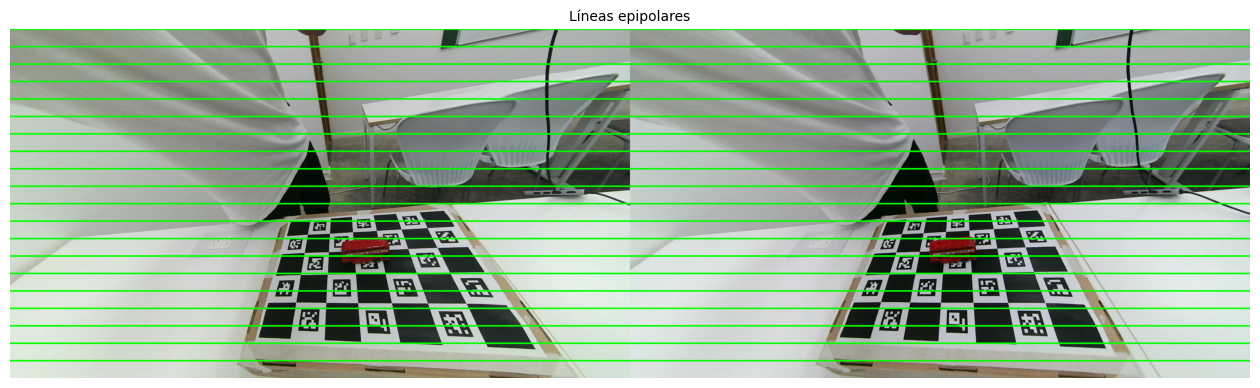

In [3]:
# Rectificamos los pares estéreo
in_dir = Path('data/captures')
out_dir = Path('data/rectified')
out_dir.mkdir(exist_ok=True)

indices = list(range(14, 38))

procesados = 0
faltantes = []

for i in indices:
    left_path = in_dir / f'left_{i}.jpg'
    right_path = in_dir / f'right_{i}.jpg'
    if not left_path.exists() or not right_path.exists():
        faltantes.append(i)
        continue

    rectL, rectR = rectify_stereo_pair(str(left_path), str(right_path), maps)

    # Guardar
    cv2.imwrite(str(out_dir / f'rect_left_{i}.jpg'), rectL)
    cv2.imwrite(str(out_dir / f'rect_right_{i}.jpg'), rectR)
    procesados += 1

print(f'Pares rectificados: {procesados}')
if faltantes:
    print('Índices faltantes:', faltantes)

# Visualizamos un par de imágenes rectificadas con líneas epipolares
combinados = draw_epipolar_lines(rectL, rectR)
imshow(combinados, title='Líneas epipolares', figsize=(16, 8))

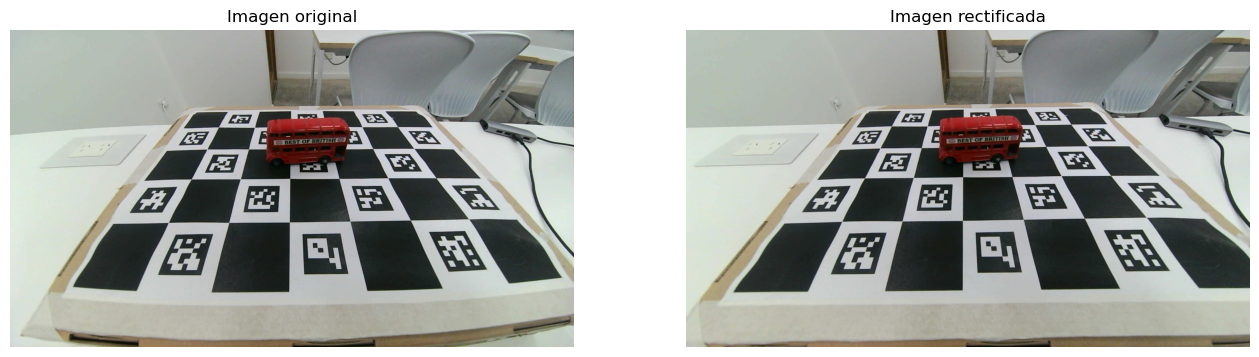

In [4]:
imgL = cv2.imread('data/captures/left_14.jpg')
rectifiedL = cv2.remap(imgL, maps['left_map_x'], maps['left_map_y'], cv2.INTER_LINEAR)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Imagen original')
plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Imagen rectificada')
plt.imshow(cv2.cvtColor(rectifiedL, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [5]:
idx_slider = IntSlider(min=14, max=37, step=1, value=14, layout={'width': '900px'})
lines_slider = IntSlider(min=5, max=50, step=5, value=20, layout={'width': '400px'})

interact(
    show_pair_any,
    idx=idx_slider,
    draw_lines=Checkbox(value=True, description='Rectificar'),
    num_lines=lines_slider,
    stereo_maps=fixed(maps)
)

interactive(children=(IntSlider(value=14, description='idx', layout=Layout(width='900px'), max=37, min=14), Ch…

<function utils.show_pair_any(idx=14, rectificar=True, num_lines=20, stereo_maps=None)>

## Cálculo de Disparidad
### Block Matching

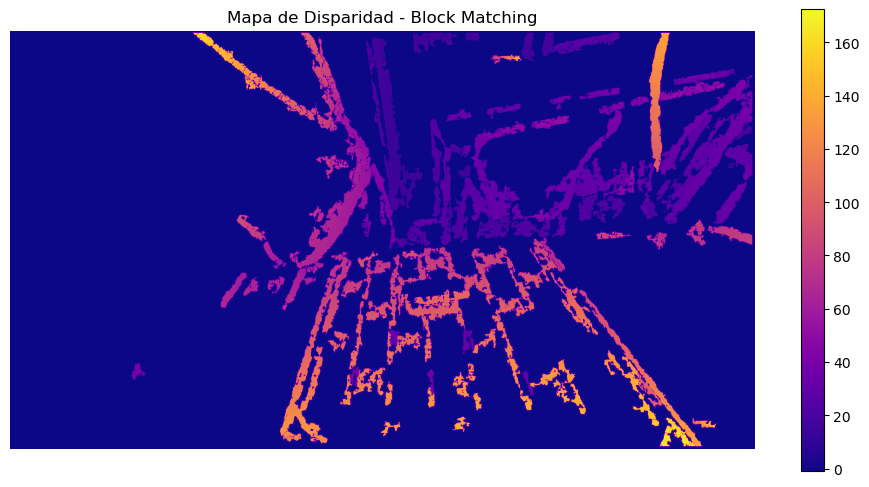

In [6]:
stereo_bm = cv2.StereoBM_create(numDisparities=256, blockSize=15)

stereo_bm.setPreFilterSize(31)
stereo_bm.setPreFilterCap(15)
stereo_bm.setMinDisparity(0)
stereo_bm.setTextureThreshold(7)
stereo_bm.setUniquenessRatio(3)
stereo_bm.setSpeckleWindowSize(512)
# stereo_bm.setSpeckleWindowSize(0)
stereo_bm.setSpeckleRange(32)
stereo_bm.setDisp12MaxDiff(23)

# Pasamos las imágenes rectificadas a escala de grises
rectL_gray = cv2.cvtColor(rectL, cv2.COLOR_BGR2GRAY)
rectR_gray = cv2.cvtColor(rectR, cv2.COLOR_BGR2GRAY)

# Cálculo del mapa de disparidad
disparity_map_bm = stereo_bm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_bm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Block Matching')
plt.axis('off')
plt.show()

### Semi-Global Block Matching

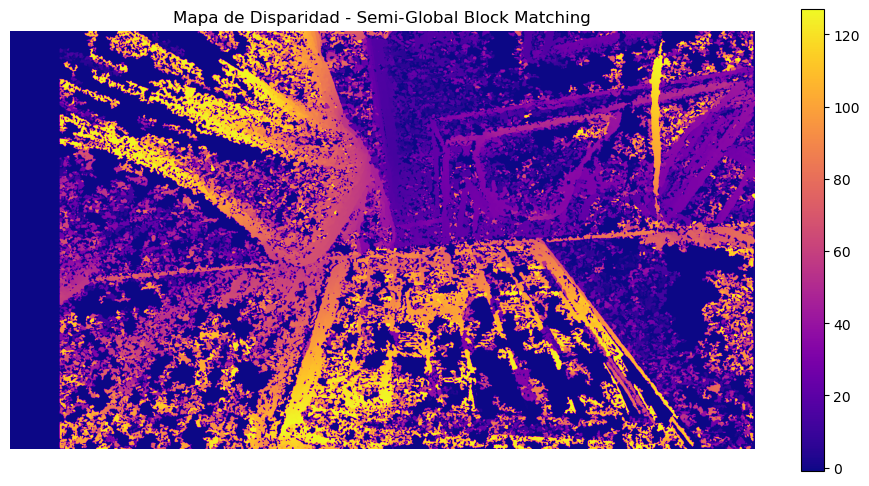

In [7]:
stereo_sgbm = cv2.StereoSGBM_create(numDisparities=128, blockSize=7)

# stereo_sgbm.setBlockSize(3)
# stereo_sgbm.setMode()

stereo_sgbm.setP1(16)
stereo_sgbm.setP2(128)
stereo_sgbm.setUniquenessRatio(7)
stereo_sgbm.setSpeckleWindowSize(512)
stereo_sgbm.setSpeckleRange(64)
stereo_sgbm.setDisp12MaxDiff(1)
stereo_sgbm.setPreFilterCap(63)

# Cálculo del mapa de disparidad
disparity_map_sgbm = stereo_sgbm.compute(
    rectL_gray,
    rectR_gray
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_sgbm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - Semi-Global Block Matching')
plt.axis('off')
plt.show()

### Cre Stereo

In [8]:
%pip install -qq onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [9]:
width, height = rectL_gray.shape[1], rectL_gray.shape[0]

fx = calib['left_K'][0][0]
fy = calib['left_K'][1][1]
cx0 = calib['left_K'][0][2]
cy0 = calib['left_K'][1][2]

baseline = np.linalg.norm(calib['T'])  # Distancia entre cámaras

models/crestereo_combined_iter5_720x1280.onnx


/opt/anaconda3/lib/python3.12/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CoreMLExecutionProvider, AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


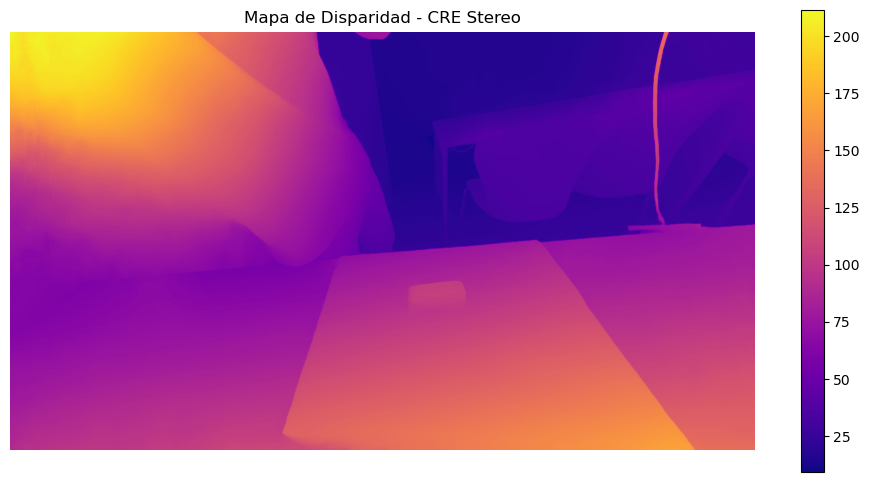

In [10]:
from disparity.methods import Calibration, InputPair, Config
from disparity.method_cre_stereo import CREStereo

calibration = Calibration(**{
    "width": width,
    "height": height,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)
models_path = Path(models_path)
pair = InputPair(
    left_image=rectL_gray,
    right_image=rectR_gray,
    calibration=calibration
)
config = Config(models_path=models_path)

cre_stereo = CREStereo(config)
cre_stereo.parameters['Shape'].set_value('1280x720')

disparity_map_cs = cre_stereo.compute_disparity(pair)
plt.figure(figsize=(12, 6))
plt.imshow(disparity_map_cs.disparity_pixels, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Disparidad - CRE Stereo')
plt.axis('off')
plt.show()

### Cálculo de Profundidad

Usamos la fórmula:
$ z = \frac{f . B}{d} $

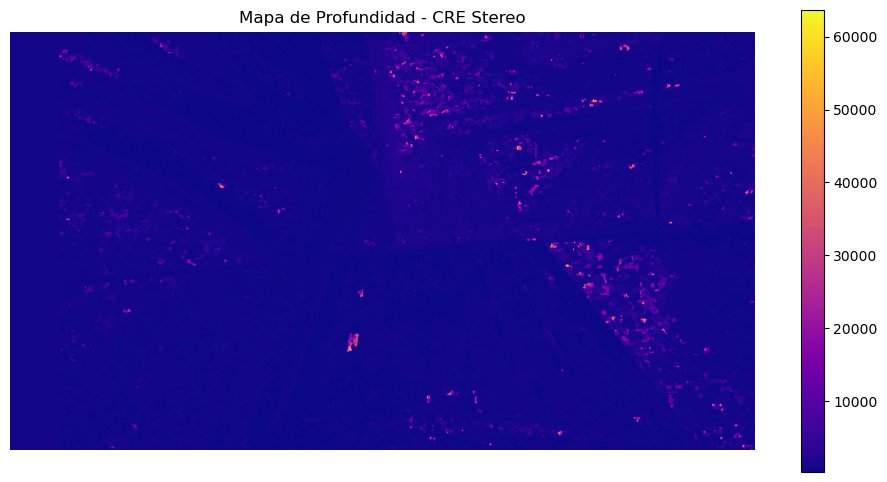

In [ ]:
# disparity_map_cs_px = disparity_map_cs.disparity_pixels

f = calib['left_K'][0][0]  # Focal en píxeles
B = baseline

depth_map_sgbm = compute_depth(disparity_map_sgbm, f, B)

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_sgbm, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Profundidad - CRE Stereo')
plt.axis('off')
plt.show()

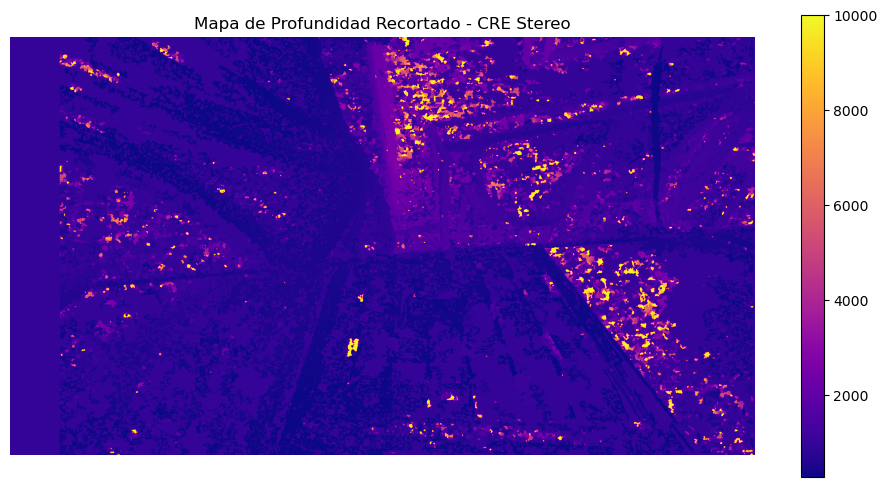

In [13]:
depth_map_sgbm2 = depth_map_sgbm.copy()
depth_map_sgbm2[depth_map_sgbm2 > 10000] = 10000

plt.figure(figsize=(12, 6))
plt.imshow(depth_map_sgbm2, cmap='plasma')
plt.colorbar()
plt.title('Mapa de Profundidad Recortado - CRE Stereo')
plt.axis('off')
plt.show()